In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Modelo con asimetría de información

$$\begin{equation}
    \begin{aligned}
        \Gamma_{t}=\sum_{s=t}^{T}[U(c_{s}, g_{s}) + V(k_{s}) + \eta_{s}]\beta^{s-t}
    \end{aligned}
    \end{equation}$$

$$c_{t} = y - \tau_{t}$$
$$g_{t} +k_{t+1} = \tau_{t} + \epsilon_{t}$$

El votante representativo se preocupa por el valor esperado de su función de utilidad  $\mathbb{E}_{t}^{P}(\Gamma_{t})$

<ul>
    <li>c representa el consumo del bien privado por parte de un ciudadano representativo.</li>
    <li>g es el consumo del bien público (per cápita)</li>
    <li>k es la inversión pública (per cápita)</li>
</ul>

$$\begin{equation}
    \begin{aligned}
        W(g, \tau, \epsilon)=U(y-\tau, g) + \beta V(\tau + \epsilon - g)
    \end{aligned}
    \end{equation}$$

Si los votantes observan el último shock de competencia del incumbente $\alpha_{i}$ antes de votar, entonces las expectativas hacia el incumbente serian.
$$ \mathbf{E}_{t}^{P}[W^{*}(\epsilon_{t+1})|\alpha_{t}=\alpha^{i}]=\Omega^{i}$$
Donde $i=H, L$ para los tipos compententes y no competentes en un modelo de senalizacion, esto quiere decir que la utilidad esperada del votante representativo está condicionada en lo que percibe del incumbente.

Para el caso del oponente, no se observa cuan competente es, entonces:
$$\mathbf{E}_{t}^{P}[W^{*}(\epsilon_{t+1}^{O})]=\Omega^{O}$$


El problema de maximizacion del incumbente de tipo $i=H, L$ seria:
$$\begin{equation}
    \begin{aligned}
        \max_{\tau, g} & \beta[X(1+\beta) + \Omega^{i}-\Omega^{O}]\pi[\hat{\rho}(g,\tau)]+ W(g, \tau, \epsilon^{i}) \\
        \text{sujeto a } & g, y- \tau, \tau + \epsilon^{i}-g \geq 0 \\
    \end{aligned}
    \end{equation}$$

Donde $\pi$ es la probabilidad esperada de que el incumbente gane, el término $X(\beta+\beta^{2})$ captura las rentas de ego descontadas para los dos periodos
posteriores a las elecciones y el termino $\beta(\Omega^{i}-\Omega^{O})$ es la cantidad por la cual la utilidad esperada del agente representativo es mayor si el incumbente gana en lugar de su oponente.

Para la probabilidad de ganar en lugar de calcularlo como el valor esperado de la funcion $v$ condicional a $g$ y $\tau$, vamos a aproximar la probabilidad con una función que toma valores entre 0 y 1 con una relación positiva en g y una negativa en tau para reflejar las preferencias de los agentes por bajos impuestos y alto consumo público, al hacer esto le permitimos al agente manipular $\tau$ y $g$.

$$\begin{equation}
    \begin{aligned}
        \pi[\hat{\rho}(\tau, g)] = \mathbf{E}^{I}(v|g, \tau)
    \end{aligned}
    \end{equation}$$

Función de elección del líder

\begin{equation}
    v_{t} =
    \begin{cases}
        1 &  \text{si } \mathbf{E}_{t}^{P}(\Gamma_{t+1}) \geq \mathbf{E}_{t}^{P}(\Gamma_{t+1}^{O})\\
        0 & \text{en otro caso}\\
\end{cases}
\end{equation}

____________________

## Definiciones 

$$\begin{equation}
    \begin{aligned}
        \pi[\hat{\rho}(\tau, g)] = \frac{1}{1+e^{dg-h\tau-\eta_{t}^{i}}}
    \end{aligned}
    \end{equation}$$

Donde: $d$ y $h$ son valores positivos que controlan la sensibilidad de la funcion logistica elegida y $\eta$ es el shock de liderazgo no relacionado con la competencia.

$$ \epsilon_{t}^{i} = \alpha_{t}^{i} + \alpha_{t-1}^{i}$$
$$ \eta_{t}^{i} = q_{t}^{i} + q_{t-1}^{i}$$

Las funciones de utilidad $U$ y $V$ son funciones regulares estrictamente concavas y satisfacen condiciones de Inada

$$U(c, g) = a \ln{c} + b\ln{g}$$
$$V(k) = -\ln{k}$$

### Parámetros

In [3]:
a, b = 1, 1     # constantes de la función de utilidad U
beta = 0.95     # Tasa de descuento intertemporal
X = 1           # Rentas de ego provenientes de ser líder

y = 10         # Producto en unidades de un bien no almacenable

T = 10          # Número máximo de periodos
t = 0           # Periodo inicial 

d = 1         # Elasticidad de la función logística para tau
h = 1         # Elasticidad de la función logística para g

### Calibración de variables aleatorias

Se eligen estos valores tanto para el incumbente como para su oponente

In [4]:
p = 0.5                 # Probabilidad de que el agente i sea competente en el periodo t
q_r = range(-5,5)     # Rango de valores donde viven los shocks de apariencia iguales para el incumbente y para el oponente

Para simplificar el modelo y dado que lo que nos interesa es solamente discriminar entre agentes competentes y no competentes, usamos una distribucion de probabilidad binomial para los shocks de apariencia

In [5]:
# Funciones que generan series aleatorias
def genera_ar1(T, p):  # Se podría definir parámetros para los valores del proceso AR(1) y hacerlo más complejo
    # Valor inicial es una variable aleatoria
    series = np.random.binomial(1, p, T+1)

    return np.array(series)

def genera_ar2(T):  # Se podría definir parámetros para los valores del proceso AR(1) y hacerlo más complejo
    # Valor inicial es una variable aleatoria
    series = np.random.choice(q_r, T+1)

    return np.array(series)

In [6]:
# Generamos las series AR(1) para los shocks de competencia alpha y los shocks de apariencia q
# Incumbente
alpha_series_i = genera_ar1(T, p)
q_series_i = genera_ar2(T)

# Oponente
alpha_series_o = genera_ar1(T, p)
q_series_o = genera_ar2(T)

In [8]:
# Calculamos epsilon y eta para el incubente y para el oponente
# Incumbente
epsilon_ti = alpha_series_i[1:] + alpha_series_i[:-1]
eta_ti = q_series_i[1:] + q_series_i[:-1]

# Oponente
epsilon_to = alpha_series_o[1:] + alpha_series_o[:-1]
eta_to = q_series_o[1:] + q_series_o[:-1]

### Funciones

Definimos las funciones que vamos a usar 

$$\begin{equation}
    \begin{aligned}
        W(g, \tau, \epsilon)=U(y-\tau, g) + \beta V(\tau + \epsilon - g)
    \end{aligned}
    \end{equation}$$

In [11]:
def W(x, y, epsilon, beta, a, b):
    tau, g = x
    c = y - tau
    k = tau + epsilon - g
    return -(a * np.log(c) + b * np.log(g) + beta * (-np.log(k)))  # Negativo porque usamos un minimizador de scipy

$$\begin{equation}
    \begin{aligned}
        \Gamma_{t}=\sum_{s=t}^{T}[U(c_{s}, g_{s}) + V(k_{s}) + \eta_{s}]\beta^{s-t}
    \end{aligned}
    \end{equation}$$

In [12]:
def gamma(x, y, eta, beta, epsilon, t, T, a, b):
    tau, g = x
    c = y - tau
    k = tau + epsilon - g
    return sum([(a * np.log(c) + b * np.log(g) + (-np.log(k[s])) + eta[s])*beta**(s-t) for s in range(t, T)])

$$\begin{equation}
    \begin{aligned}
        \pi[\hat{\rho}(\tau, g)] = \frac{1}{1+e^{dg-h\tau-\eta_{t}^{i}}}
    \end{aligned}
    \end{equation}$$

In [13]:
def pi(x, d, h, eta_i):
    tau, g = x
    return 1/(1+np.exp(d*g-h*tau-eta_i))

Definimos una función que optimiza la función W para cada periodo de tiempo, ya que será usada como insumo en la función principal del modelo

$$\begin{equation}
    \begin{aligned}
        \mathbf{E}_{t}^{P}[W^{*}(\epsilon_{t+1})|\alpha_{t}=\alpha^{i}]=\Omega^{i}
        \end{aligned}
    \end{equation}$$
Con $i=H, L$ para los tipos con alta competencia o baja competencia respectivamente

$$\begin{equation}
    \begin{aligned}
        \mathbf{E}_{t}^{P}[W^{*}(\epsilon_{t+1}^{O})]=\Omega^{O}
        \end{aligned}
    \end{equation}$$

Donde $W^{*}(\epsilon)=W^{*}[g^{*}(\epsilon), \tau^{*}(\epsilon), \epsilon]$ viene de resolver
\begin{equation}
    \begin{aligned}
        \max_{\tau, g} & U(y-\tau, g)+\beta V(\tau + \epsilon - g) \\
        \text{sujeto a } & g, y- \tau, \tau + \epsilon-g \geq 0 \\
   \end{aligned}
\end{equation}

Para la maximización que el optimizador de scipy lo resuelve iterando la función de valor debemos proporcionar un valor inicial

In [14]:
# Guess inicial (Por ahora tau y g empiezan tomando valores en la mitad de su rango permitido)
x0 = [y/2, y/4]

Restricciones para la maximizacion

In [15]:
def constraint1(x, y):
    # y - tau >= 0
    return y - x[0]

def constraint2(x):
    # g >= 0
    return x[1]

def constraint3(x, epsilon):
    # tau + epsilon - g >= 0
    return x[0] + epsilon - x[1]

In [16]:
def optimizador_W(T, y, beta, a, b, epsilon):
    tau_optimo = []
    g_optimo = []
    valores_max = []

    for t in range(T):
        # Itera sobre los valores de competencia del agente
        epsilon_t = epsilon[t]

        # Restricciones por cada periodo de tiempo(epsilon)
        con1 = {'type': 'ineq', 'fun': constraint1, 'args': (y,)}
        con2 = {'type': 'ineq', 'fun': constraint2}
        con3 = {'type': 'ineq', 'fun': constraint3, 'args': (epsilon_t,)}

        # Combinamos las restricciones en una lista
        constraints_t = [con1, con2, con3]

        # Optimiza para ese periodo de tiempo t
        resultado_t = minimize(W, x0, args=(y, epsilon_t, beta, a, b), constraints=constraints_t)

        # Guarda los resultados para cada periodo de tiempo
        tau_optimo.append(resultado_t.x[0])
        g_optimo.append(resultado_t.x[1])
        valores_max.append(resultado_t.fun)

    return tau_optimo, g_optimo, valores_max

Estimacion bayesiana de los valores de Omega

Esta estimacion puede llegar a ser mas compleja y requerir metodos numericos, en este caso se lo estima de una forma rudimentaria de acuerdo a la teoria bayesiana

In [17]:
# Solo para el incumbente, porque no podemos condicionar para el oponente, usamos solo una implementación rudimentaria de la teoría bayesiana
# valor a priori
p_prior = 0.3

# Generamos alpha prior
alpha_prior = genera_ar1(T, p_prior)

# Buscamos actualizar p con los valores observados de epsilon_ti, expectativas adaptativas asumiendo que epsilon_ti es el valor observado
# Esto es una versión simplificada ya que se podrían usar métodos numéricos
mu_observado = np.mean(alpha_prior)
sigma_observado = np.std(alpha_prior) / np.sqrt(len(alpha_prior))

p_posterior = 1 - sigma_observado/mu_observado  # según una distribución binomial

# Simulamos los valores futuros de alpha asumiendo p_posterior que condiciona en el valor observado
alpha_simulado = genera_ar1(T, p_posterior)
epsilon_simulado = alpha_simulado[1:] + alpha_simulado[:-1]

In [21]:
# Calculamos los Omega como el valor esperado de la maximización de W considerando los diferentes epsilon y la funcion que optimiza w en cada periodo t en T
# Para Omega_i
for epsilon in epsilon_simulado:  # Optimiza Omega con los epsilon conditionados
    _, _, u_i = optimizador_W(T, y, beta, a, b, epsilon_simulado)

Omega_i = np.mean(u_i) # valor esperado

# Para Omega_O 
for epsilon in epsilon_to:  # Con los valores reales del epsilon del oponente, ya que no tenemos informacion sobre el
    _, _, u_o = optimizador_W(T, y, beta, a, b, epsilon_to)

Omega_o = np.mean(u_o) # valor esperado

/tmp/ipykernel_18713/4070151217.py:5: RuntimeWarning: invalid value encountered in log
  return -(a * np.log(c) + b * np.log(g) + beta * (-np.log(k)))  # Negativo porque usamos un minimizador de scipy
/tmp/ipykernel_18713/4070151217.py:5: RuntimeWarning: divide by zero encountered in log
  return -(a * np.log(c) + b * np.log(g) + beta * (-np.log(k)))  # Negativo porque usamos un minimizador de scipy


Ahora si definimos la función del modelo con asimetría de información

$$\begin{equation}
    \begin{aligned}
        \max_{\tau, g} & \beta[X(1+\beta) + \Omega^{i}-\Omega^{O}]\pi[\hat{\rho}(g,\tau)]+ W(g, \tau, \epsilon^{i}) \\
        \text{sujeto a } & g, y- \tau, \tau + \epsilon^{i}-g \geq 0 \\
    \end{aligned}
    \end{equation}$$

In [24]:
def asimetria(x, X, beta, y, a, b, epsilon_ti, Omega_i, Omega_o, d, h, eta_ti):
    tau, g = x
    ego = X*(beta + beta*beta)           # rentas de ego descontadas
    omega = beta*(Omega_i - Omega_o)     # es la cantidad por la cual la utilidad esperada del agente representativo es mayor si el incumbente gana en lugar de su oponente.

   
    return  -((ego + omega))*beta*(1/(1+np.exp(d*g-h*tau-eta_ti)) + a * np.log(y - tau) + b * np.log(g) + beta * (-np.log(tau + epsilon_ti - g)))

Resolvemos el problema de maximización del incumbente considerando restricciones.
Usamos la función 'differential_evolution' de SciPy, del módulo optimize. Esta función optimiza problemas de forma global, está diseñada para encontrar el máximo o el mínimo global de una función multivariada. Este algoritmo es mejor lidiando con funciones no lineales, no convexas, ruidosas o con una función objetivo discontinua.

El algoritmo empieza con una población de candidatos a solución y luego itera sobre estos valores mejorando el resultado a través de transformaciones a los valores.

Al utilizar una población de valores para lo cual es necesario definir 'bounds' evitamos quedar atrapados en mínimos locales.

Los nuevos candidatos son alcanzados combinando los anteriores de acuerdo a ciertas reglas, luego selecciona el mejor candidato y repite el proceso.

No requiere el gradiente de la función lo que para este caso es más fácil, debido a la complejidad de la función y los términos estocásticos.

In [25]:
def asimetria_con_restricciones(x, X, beta, y, a, b, epsilon_ti, Omega_i, Omega_o, d, h, eta_ti):
    # Revisamos las restricciones
    if constraint1(x, y) < 0 or constraint2(x) < 0 or constraint3(x, epsilon_ti) < 0:
        return np.inf  # Devuelve un valor muy grande si las restricciones no se cumplen esto ayuda al algoritmo a saltar valores que no cumplen las restricciones

    # Funcion asimetria original si se cumplen las restricciones
    return asimetria(x, X, beta, y, a, b, epsilon_ti, Omega_i, Omega_o, d, h, eta_ti)

bounds = [(0.1, y), (0.1, y)]   # Para el algortimo de differential_evolution es necesario definir limites, tau y g pueden tomar valores entre 0.1 y y

# Ahora optimizamos usando asimetria y las restricciones
resultado = differential_evolution(
    lambda x: asimetria_con_restricciones(x, X, beta, y, a, b, epsilon_ti[0], Omega_i, Omega_o, d, h, eta_ti[0]),
    bounds
)

# Valores óptimos
tau_optimal, g_optimal = resultado.x


___________________________

### Equilibrios Secuenciales

Definimos una función que optimiza en diferentes momentos del tiempo donde vamos a elegir la frecuencia de las elecciones, en cada periodo, si el periodo es electoral el incumbente maximiza su funcion con asimetria de informacion y en el caso de que el periodo no sea electoral, el incumbente maximiza la funcion con informacion completa

In [28]:
def equilibrios_secuenciales(T, av, X, beta, y, a, b, epsilon_ti, Omega_i, Omega_o, d, h, eta_ti):
    periodos = range(T)
    elecciones = [1 if i % av == 0 else 0 for i in range(T)]
    tau_seq = []
    g_seq = []


    for t in periodos:
        # En periodos no electorales elecciones == 0
        if elecciones[t] == 0:
            # Itera sobre los valores de competencia del agente
            epsilon_t = epsilon_ti[t]

            # Restricciones por cada periodo de tiempo(epsilon)
            con1 = {'type': 'ineq', 'fun': constraint1, 'args': (y,)}
            con2 = {'type': 'ineq', 'fun': constraint2}
            con3 = {'type': 'ineq', 'fun': constraint3, 'args': (epsilon_t,)}

            # Combinamos las restricciones en una lista
            constraints_t = [con1, con2, con3]

            # Optimizacion en un periodo no electoral
            resultado_t = minimize(W, x0, args=(y, epsilon_t, beta, a, b), constraints=constraints_t)

            # Guarda los resultados para cada periodo de tiempo
            tau_seq.append(resultado_t.x[0])
            g_seq.append(resultado_t.x[1])

            #print("Epsilon incumbente: ", epsilon_t)
        
        # En periodos electorales elecciones == 1
        else:
            epsilon_t = epsilon_ti[t]
            eta_t = eta_ti[t]

            bounds = [(0.1, y), (0.1, y)]
            
            # Realizar la optimización
            resultado_t = differential_evolution(
                  lambda x: asimetria_con_restricciones(x, X, beta, y, a, b, epsilon_t, Omega_i, Omega_o, d, h, eta_t),
                  bounds
            )

            # Guarda los resultados para cada periodo de tiempo
            tau_seq.append(resultado_t.x[0])
            g_seq.append(resultado_t.x[1])

            #print("Epsilon incumbente: ", epsilon_ti[t])
            #print("Epsilon oponente: ", epsilon_to[t])

    for t in range(T):
        print("Periodo --", t)
        print("Es periodo electoral --", "Si" if elecciones[t] == 1 else "No")
        print("tau óptimo:", round(tau_seq[t], 4),"    |  " "g óptimo:", round(g_seq[t], 4))
        print("Schock incumbente:", epsilon_ti[t],"  |  " "Shock oponente:", epsilon_to[t], "\n")

    return tau_seq, g_seq, elecciones

In [30]:
equilibrios_secuenciales(T, 2, X, beta, y, a, b, epsilon_ti, Omega_i, Omega_o, d, h, eta_ti)

/tmp/ipykernel_18713/4070151217.py:5: RuntimeWarning: divide by zero encountered in log
  return -(a * np.log(c) + b * np.log(g) + beta * (-np.log(k)))  # Negativo porque usamos un minimizador de scipy
/tmp/ipykernel_18713/4070151217.py:5: RuntimeWarning: invalid value encountered in log
  return -(a * np.log(c) + b * np.log(g) + beta * (-np.log(k)))  # Negativo porque usamos un minimizador de scipy


Periodo -- 0
Es periodo electoral -- Si
tau óptimo: 6.9318     |  g óptimo: 2.6769
Schock incumbente: 1   |  Shock oponente: 0 

Periodo -- 1
Es periodo electoral -- No
tau óptimo: 3.1014     |  g óptimo: 5.1014
Schock incumbente: 2   |  Shock oponente: 1 

Periodo -- 2
Es periodo electoral -- Si
tau óptimo: 7.1084     |  g óptimo: 8.0594
Schock incumbente: 1   |  Shock oponente: 2 

Periodo -- 3
Es periodo electoral -- No
tau óptimo: 3.5207     |  g óptimo: 4.5207
Schock incumbente: 1   |  Shock oponente: 2 

Periodo -- 4
Es periodo electoral -- Si
tau óptimo: 2.8941     |  g óptimo: 1.0582
Schock incumbente: 1   |  Shock oponente: 1 

Periodo -- 5
Es periodo electoral -- No
tau óptimo: 3.5207     |  g óptimo: 4.5207
Schock incumbente: 1   |  Shock oponente: 0 

Periodo -- 6
Es periodo electoral -- Si
tau óptimo: 8.1232     |  g óptimo: 5.5292
Schock incumbente: 1   |  Shock oponente: 1 

Periodo -- 7
Es periodo electoral -- No
tau óptimo: -155.1444     |  g óptimo: 228.7707
Schock in

([6.931791560333128,
  3.101377775403834,
  7.1083869733681375,
  3.5206750767527564,
  2.894068700144879,
  3.5206750767527564,
  8.123164864008624,
  -155.14442854132244,
  3.8938505690237406,
  3.5206750767527564],
 [2.6768744828833597,
  5.101377775403834,
  8.05943478278429,
  4.520675076752703,
  1.0582172499929312,
  4.520675076752703,
  5.529172735315601,
  228.77068748300871,
  3.2762103764619415,
  4.520675076752703],
 [1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

## Gráficos

In [31]:
# Definición de la función pi
def pi(x, d, h, eta_i):
    tau, g = x
    return 1 / (1 + np.exp(d * g + h * tau - eta_i))

# Valores de d, h y un rango de tau y g para graficar
d = 1
h = 1
tau_range = np.linspace(0, 10, 100)
g_range = np.linspace(0, 10, 100)

# Valores de epsilon para probar
eta_values = [1, -1, 0, 2]

for eta in eta_values:
    pi_values = [pi([tau, g], d, h, eta) for tau in tau_range for g in g_range]
    pi_matrix = np.reshape(pi_values, (len(tau_range), len(g_range)))


In [32]:
pi_values

[0.8807970779778823,
 0.8697771594221244,
 0.857902839265537,
 0.8451385453887023,
 0.8314529251555348,
 0.8168200027793482,
 0.801220400306993,
 0.7846425896957999,
 0.767084134444559,
 0.7485528706953373,
 0.7290679705013879,
 0.7086608250294356,
 0.6873756838349314,
 0.6652699889290161,
 0.6424143498224886,
 0.6188921183736815,
 0.5947985398527308,
 0.5702394783322879,
 0.5453297388885201,
 0.5201910342008078,
 0.4949496667108436,
 0.46973401723175856,
 0.44467194473763094,
 0.41988820852221315,
 0.395502022282888,
 0.37162484014211505,
 0.34835845820667266,
 0.325793493730694,
 0.3040082794819692,
 0.2830681858395916,
 0.26302535963951745,
 0.2439188485923478,
 0.22577506442447592,
 0.2086085273260449,
 0.1924228288368299,
 0.1772117495027971,
 0.16296047070232167,
 0.14964682600680096,
 0.13724254530265328,
 0.125714453727536,
 0.11502559647246441,
 0.10513626906206397,
 0.09600494042300453,
 0.08758906263410368,
 0.07984576661461423,
 0.07273244715626795,
 0.06620724372513455,
 0

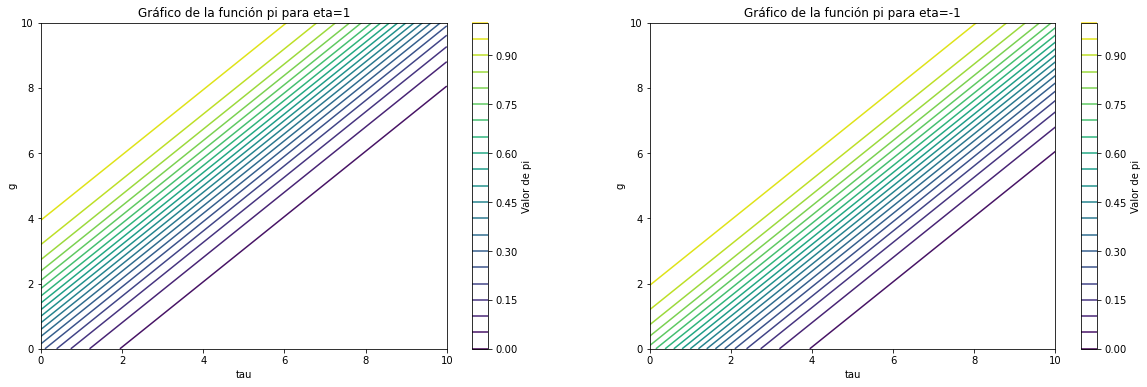

In [33]:
# Definición de la función pi
def pi(x, d, h, eta_i):
    tau, g = x
    return 1 / (1 + np.exp(d * g - h * tau + eta_i))

# Valores de d, h y un rango de tau y g para graficar
d = 1
h = 1
tau_range = np.linspace(0, 10, 100)
g_range = np.linspace(0, 10, 100)

# Valores de epsilon para probar
eta_values = [1, -1]

# Crear la gráfica con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Definir colores para cada valor de eta
for idx, eta in enumerate(eta_values):
    ax = axes[idx]
    pi_values = [pi([tau, g], d, h, eta) for tau in tau_range for g in g_range]
    pi_matrix = np.reshape(pi_values, (len(tau_range), len(g_range)))
    contour = ax.contour(tau_range, g_range, pi_matrix, levels=20, cmap='viridis')
    ax.set_title(f"Gráfico de la función pi para eta={eta}")
    ax.set_xlabel("tau")
    ax.set_ylabel("g")
    fig.colorbar(contour, ax=ax, label="Valor de pi")

plt.show()

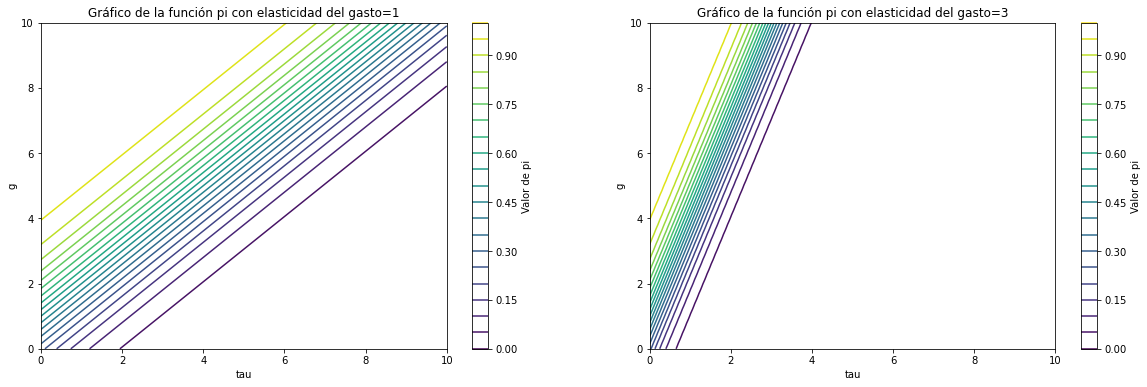

In [34]:
# Definición de la función pi
def pi(x, d, h, eta_i):
    tau, g = x
    return 1 / (1 + np.exp(d * g - h * tau + eta_i))

# Valores de d, h y un rango de tau y g para graficar
d = 1
h = 1
tau_range = np.linspace(0, 10, 100)
g_range = np.linspace(0, 10, 100)
eta = 1

# Valores de epsilon para probar
d_values = [1, 3]

# Crear la gráfica con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Definir colores para cada valor de eta
for idx, d in enumerate(d_values):
    ax = axes[idx]
    pi_values = [pi([tau, g], d, h, eta) for tau in tau_range for g in g_range]
    pi_matrix = np.reshape(pi_values, (len(tau_range), len(g_range)))
    contour = ax.contour(tau_range, g_range, pi_matrix, levels=20, cmap='viridis')
    ax.set_title(f"Gráfico de la función pi con elasticidad del gasto={d}")
    ax.set_xlabel("tau")
    ax.set_ylabel("g")
    fig.colorbar(contour, ax=ax, label="Valor de pi")

plt.show()

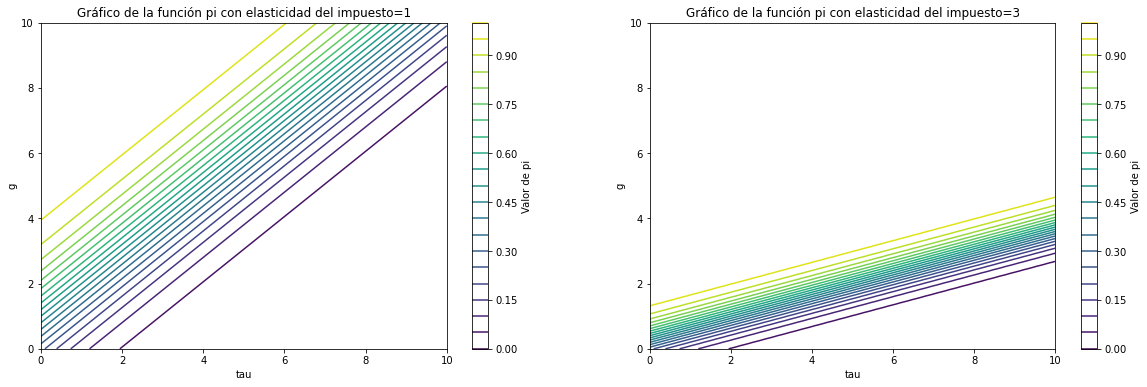

In [35]:
# Definición de la función pi
def pi(x, d, h, eta_i):
    tau, g = x
    return 1 / (1 + np.exp(d * g - h * tau + eta_i))

# Valores de d, h y un rango de tau y g para graficar
d = 1
h = 1
tau_range = np.linspace(0, 10, 100)
g_range = np.linspace(0, 10, 100)
eta = 1

# Valores de epsilon para probar
h_values = [1, 3]

# Crear la gráfica con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Definir colores para cada valor de eta
for idx, h in enumerate(d_values):
    ax = axes[idx]
    pi_values = [pi([tau, g], d, h, eta) for tau in tau_range for g in g_range]
    pi_matrix = np.reshape(pi_values, (len(tau_range), len(g_range)))
    contour = ax.contour(tau_range, g_range, pi_matrix, levels=20, cmap='viridis')
    ax.set_title(f"Gráfico de la función pi con elasticidad del impuesto={h}")
    ax.set_xlabel("tau")
    ax.set_ylabel("g")
    fig.colorbar(contour, ax=ax, label="Valor de pi")

plt.show()

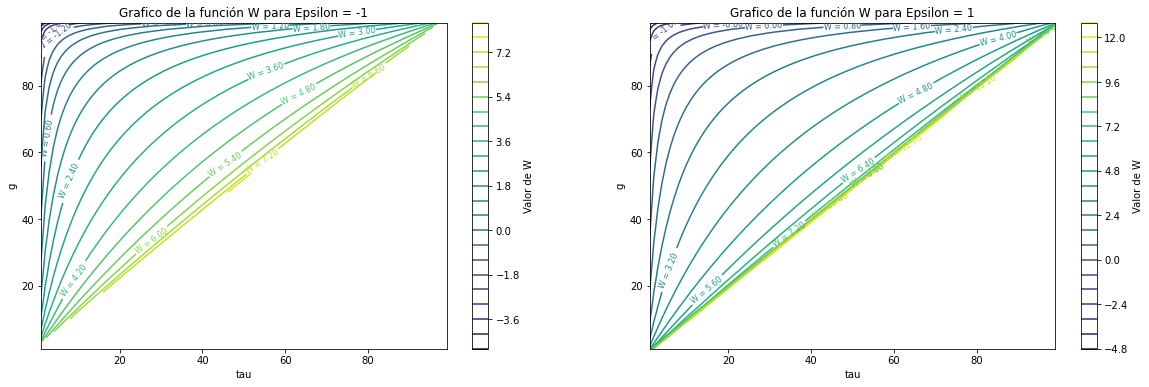

In [36]:
# Definición de la función W
def W(x, y, epsilon, beta, a, b):
    tau, g = x
    c = y - tau
    k = tau + epsilon - g
    # Asegurarse de que c, g, y k sean mayores que 0 para evitar errores con np.log
    if c <= 0 or g <= 0 or k <= 0:
        return np.inf
    return (a * np.log(c) + b * np.log(g) + beta * (-np.log(k)))

# Parámetros
y = 100
beta = 0.95
a = 1
b = 1

# Rango de valores para tau y g
tau_range = np.linspace(1, 99, 100)
g_range = np.linspace(1, 99, 100)

# Valores de epsilon para probar
epsilon_values = [-1, 1]

# Crear la gráfica con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Graficar la función para diferentes valores de epsilon
for idx, epsilon in enumerate(epsilon_values):
    ax = axes[idx]
    W_values = np.array([W([tau, g], y, epsilon, beta, a, b) for tau in tau_range for g in g_range])
    W_matrix = W_values.reshape(len(tau_range), len(g_range))
    contour = ax.contour(tau_range, g_range, W_matrix, levels=20, cmap='viridis')
    ax.set_title(f"Grafico de la función W para Epsilon = {epsilon}")
    ax.set_xlabel("tau")
    ax.set_ylabel("g")
    plt.clabel(contour, inline=1, fontsize=8, fmt=lambda lvl: f"W = {lvl:.2f}")
    fig.colorbar(contour, ax=ax, label="Valor de W")

plt.show()

Los competentes tienen una utilidad mas baja con el mismo deficit fiscal que tendria un incompetente, por lo que ser compentente y tener un deficit fiscal puede considerarse negativo en terminos de bienestar, es el costo extra que tendrian los competentes en fallar.